In [6]:
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# import imageio
from PIL import Image


def get_time_string():
    now = datetime.now()
    return now.strftime("%d_%H_%M_%S")

In [7]:
"""agent class"""

class Agent:
    def __init__(
        self,
        group: int,
        init_position: tuple[int],
        init_fitness: float,
        id=int,
    ):
        self.group = group
        self.position_hist = [init_position]
        self.fitness_hist = [init_fitness]
        self.id = id

    @property
    def position(self):
        return self.position_hist[-1]

    @property
    def fitness(self):
        return self.fitness_hist[-1]

    def add_unchanged_step(self):
        pos, fit = self.position, self.fitness
        self.position_hist.append(pos)
        self.fitness_hist.append(fit)

    def move_position(self, L):
        x, y = self.position

        move_axis = np.random.choice([0, 1])

        if move_axis == 0:
            dx = np.random.choice([-1, 1])
            x = int(np.clip(x + dx, 0, L-1))
        else:
            dy = np.random.choice([-1, 1])
            y = int(np.clip(y + dy, 0, L-1))
        self.position_hist.append((x, y))


In [10]:
"""game class"""

class Game:
    def __init__(
        self,
        n_a: int,
        n_b: int,
        grid_size: int = 25,
        eta: float = 10,
        x: float = 0.05,
    ):
        self.groups = ["A", "B"]
        # input args
        self.n_a = n_a
        self.n_b = n_b
        self.grid_size = grid_size
        self.eta = eta
        self.x = x
        
        # deduced args
        self.n = n_a + n_b
        self.init_fitness = 1000 / self.n
        self.p_a = self.n_a / self.n
        self.p_b = self.n_b / self.n

        # to be modular in case we need to add a third group for example
        self.demography = {"A": self.n_a, "B": self.n_b}

        # population
        self.population = self.init_population()

        # min/max fitness
        self.extreme_fitness = self.init_extreme_fitness()

        # plot colors
        self.plot_colors = {"A": "Blues", "B": "Greens"}

        # saving path
        self.path = os.path.join("interactions", get_time_string())
        self.path_grid = os.path.join(self.path, "grid")
        os.mkdir(self.path)
        os.mkdir(self.path_grid)

    def play_game(
        self, t_max: int, save_every: int | None = None, plot: bool = False
    ):
        """Plays according to the diagram of the paper."""
        for t in tqdm.tqdm(range(t_max)):
            self.play_one_iter()
            # plot
            if save_every is not None and t % save_every == 0:
                self.plot_current_situation(t, plot=plot)
        # plot
        self.plot_fitness(t_max, plot=plot)


    def play_one_iter(self):
        """Play one iteration of the game"""
        self.update_extreme_fitness()
        # move
        self.move_all_agents()
        self.update_all_normalized_fitness()
        self.check_and_do_fight()



    def move_all_agents(self):
        """Moves all agents (from both groups) and rebuilds the grid."""
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]

        for group in self.groups:
            for agent in self.population[group].values():
                agent.move_position(self.grid_size)
                x, y = agent.position
                self.grid[x][y].append(agent)

    def check_and_do_fight(self):
        """For each cell, lets at most one pair of agents from opposite groups fight."""
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                agents = self.grid[x][y]

                if len(agents) >= 2:
                    # separe groups
                    group_A_agents = [a for a in agents if a.group == "A"]
                    group_B_agents = [a for a in agents if a.group == "B"]

                    if group_A_agents and group_B_agents:
                        # choose an agent to fight from each group
                        agent_A = np.random.choice(group_A_agents)
                        agent_B = np.random.choice(group_B_agents)

                        self.fight(agent_A, agent_B)

                        # every other agent remains spectator
                        for agent in agents:
                            if agent not in [agent_A, agent_B]:
                                agent.fitness_hist.append(agent.fitness)

                    else: #if they are all in the same group 
                        for agent in agents:
                            agent.fitness_hist.append(agent.fitness)

                elif len(agents)==1:
                    agents[0].fitness_hist.append(agents[0].fitness)



    def fight(self, agent_1, agent_2):
        """Compute the winning probability and exchange fitness, using precomputed normalized values."""
        # Convention : agent_1 est dans le groupe A
        if agent_1.group == "B":
            agent_1, agent_2 = agent_2, agent_1

        f1, f2 = agent_1.fitness, agent_2.fitness
        f1_norm, f2_norm = agent_1.fitness_norm, agent_2.fitness_norm

        p_win = 1 / (1 + np.exp(self.eta * (f2_norm - f1_norm)))
        u = np.random.rand()

        if u < p_win:
            agent_1.fitness_hist.append(f1 + self.x * f2)
            agent_2.fitness_hist.append(f2 - self.x * f2)
        else:
            agent_1.fitness_hist.append(f1 - self.x * f1)
            agent_2.fitness_hist.append(f2 + self.x * f1)


    def update_extreme_fitness(self):
        """Update the min/max fitness"""
        for group in self.groups:
            _, fitness = self.get_current_info_group(group)
            self.extreme_fitness[group]["min"].append(np.min(fitness))
            self.extreme_fitness[group]["max"].append(np.max(fitness))

    # --------------------------#
    # --------------------------#
    # ----    ACCESS INFO   ----#
    # --------------------------#
    # --------------------------#

    def update_all_normalized_fitness(self):
        """Compute and store normalized fitness for all agents in both groups."""
        for group in self.groups:
            f_min = self.extreme_fitness[group]["min"][-1]
            f_max = self.extreme_fitness[group]["max"][-1]
            eps = 1e-10

            for agent in self.population[group].values():
                f = agent.fitness
                agent.fitness_norm = (f - f_min + eps) / (f_max - f_min + eps)


    def get_current_info_group(self, group: str):
        positions = []
        fitness = []
        for idx_agent in self.population[group]:
            positions.append(self.population[group][idx_agent].position)
            fitness.append(self.population[group][idx_agent].fitness)

        return np.array(positions), np.array(fitness)

    # --------------------------#
    # --------------------------#
    # ----  INITIALIZATION  ----#
    # --------------------------#
    # --------------------------#

    def init_population(self):
        """Init the population with random positions"""
        pop = {group: {} for group in self.groups}
        for group, n_group in self.demography.items():
            for idx in range(n_group):
                init_pos = self.get_random_position()
                pop[group][idx] = Agent(group, init_pos, self.init_fitness, idx)

        return pop

    def init_extreme_fitness(self):
        """Init the extreme fitness."""
        init_fit = self.init_fitness
        extreme_fitness = {
            group: {"min": [init_fit], "max": [init_fit]}
            for group in self.groups
        }
        return extreme_fitness

    def get_random_position(self):
        """Chose a random position on the grid"""
        random_x = np.random.randint(0, self.grid_size)
        random_y = np.random.randint(0, self.grid_size)
        return (random_x, random_y)

    # --------------------------#
    # --------------------------#
    # ----  PLOTTING UTILS  ----#
    # --------------------------#
    # --------------------------#

    def plot_fitness(self, t_max, plot: bool = False):
        """Plot the fitness evolution during the game."""
        for group in self.groups:
            for idx in tqdm.tqdm(self.population[group]):
                self.population[group][idx].position_hist = 0

        for group in self.groups:
            plt.figure()
            plt.title(f"Group {group}")
            for idx in tqdm.tqdm(self.population[group]):
                assert (
                    len(self.population[group][idx].fitness_hist) == t_max + 1
                )
                plt.plot(self.population[group][idx].fitness_hist)
                plt.grid()
            plt.savefig(os.path.join(self.path, f"fitness_{group}.png"))
            if plot:
                plt.show()
            plt.close()

    def plot_current_situation(self, step: int, plot: bool):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Time {step}")
        for idx, group in enumerate(self.groups):
            position_b, fitness_b = self.get_current_info_group(group)
            sc2 = axes[idx].scatter(
                position_b[:, 0],
                position_b[:, 1],
                c=fitness_b,
                cmap=self.plot_colors[group],
                vmin=np.min(fitness_b),
                vmax=np.max(fitness_b),
            )
            fig.colorbar(sc2, ax=axes[idx], label="Fitness")
            axes[idx].set_title(f"Group {group}")
            axes[idx].grid()
            axes[idx].set_xticks(np.arange(self.grid_size + 1))
            axes[idx].set_yticks(np.arange(self.grid_size + 1))
            axes[idx].set_aspect("equal")
            axes[idx].set_xlim((-0.5, self.grid_size + 0.5))
            axes[idx].set_ylim((-0.5, self.grid_size + 0.5))

        plt.savefig(os.path.join(self.path_grid, f"{str(step)}.png"), dpi=100)
        if plot:
            plt.show()
        plt.close()

# **Simulations**

In [21]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 5
x = 0.01

## **Group B**

100%|██████████| 50/50 [00:00<00:00, 930.04it/s]


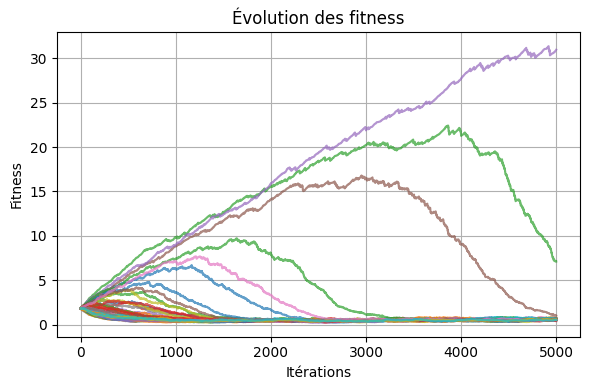

In [22]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

# Tracer l'évolution de la fitness pour chaque agent
plt.figure(figsize=(6, 4))

group = "B"
for agent in game.population[group].values():
    plt.plot(agent.fitness_hist, label=f"{group}_{agent.id}", alpha=0.7)

plt.title("Évolution des fitness")
plt.xlabel("Itérations")
plt.ylabel("Fitness")
plt.grid(True)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:00<00:00, 89.79it/s] 


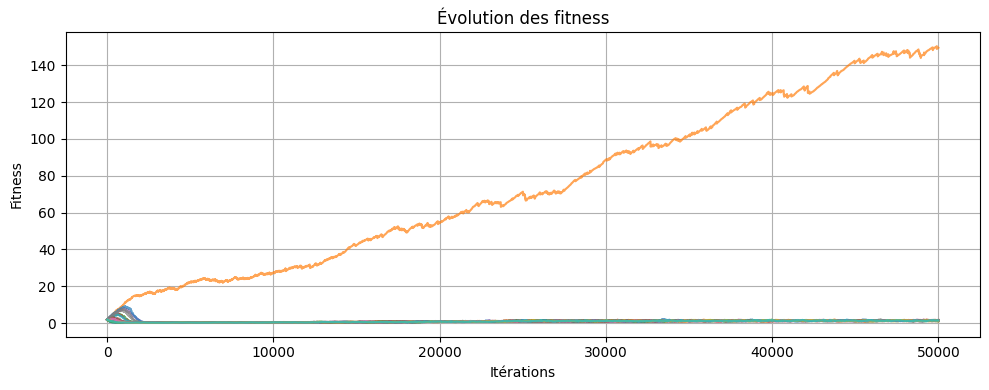

In [19]:
### Long term : stationnary result (150000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=150000, save_every=None, plot=False)

# Tracer l'évolution de la fitness pour chaque agent
plt.figure(figsize=(10, 4))

group = "B"
for agent in game.population[group].values():
    plt.plot(agent.fitness_hist, label=f"{group}_{agent.id}", alpha=0.7)

plt.title("Évolution des fitness")
plt.xlabel("Itérations")
plt.ylabel("Fitness")
plt.grid(True)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## **Group A**

100%|██████████| 50/50 [00:00<00:00, 727.24it/s]


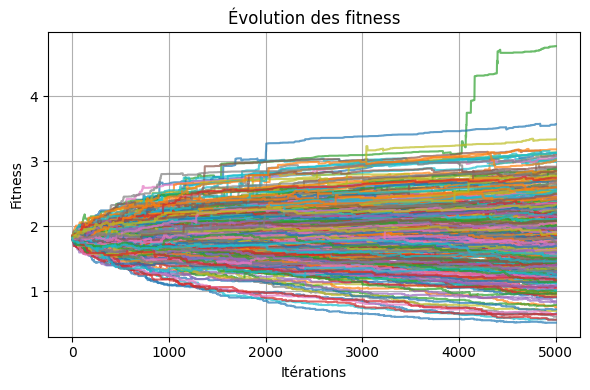

In [23]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

# Tracer l'évolution de la fitness pour chaque agent
plt.figure(figsize=(6, 4))

group = "A"
for agent in game.population[group].values():
    plt.plot(agent.fitness_hist, label=f"{group}_{agent.id}", alpha=0.7)

plt.title("Évolution des fitness")
plt.xlabel("Itérations")
plt.ylabel("Fitness")
plt.grid(True)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## **Dependence on $\rho$**

In [ ]:
## TO DO

## **Gini coeffs and Lorenz curve**

In [38]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 5
x = 0.01

In [39]:
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

100%|██████████| 50/50 [00:00<00:00, 955.84it/s]


In [40]:
def lorenz_curve(values: np.ndarray):
    """Return cumulative values for plotting the Lorenz curve."""
    sorted_vals = np.sort(values)
    cumvals = np.cumsum(sorted_vals)
    cumvals = np.insert(cumvals, 0, 0)  # Start at 0
    cumvals = cumvals / cumvals[-1]
    x_vals = np.linspace(0, 1, len(cumvals))
    return x_vals, cumvals

def gini_coefficient(values: np.ndarray):
    """Compute the Gini coefficient from a list/array of values."""
    sorted_vals = np.sort(values)
    n = len(values)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * sorted_vals) / (n * np.sum(sorted_vals))) - (n + 1) / n


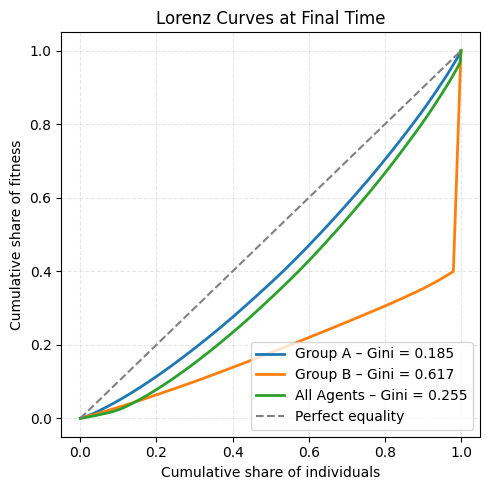

In [41]:
## Lorenz curves
fitness_start_A = np.array([agent.fitness_hist[0] for agent in game.population["A"].values()])
fitness_end_A = np.array([agent.fitness_hist[-1] for agent in game.population["A"].values()])

fitness_start_B = np.array([agent.fitness_hist[0] for agent in game.population["B"].values()])
fitness_end_B = np.array([agent.fitness_hist[-1] for agent in game.population["B"].values()])

fitness_start_all = np.concatenate([fitness_start_A, fitness_start_B])
fitness_end_all = np.concatenate([fitness_end_A, fitness_end_B])

xA_end, yA_end = lorenz_curve(fitness_end_A)
xB_end, yB_end = lorenz_curve(fitness_end_B)
xAll_end, yAll_end = lorenz_curve(fitness_end_all)

## Gini coefficients
gini_A = gini_coefficient(fitness_end_A)
gini_B = gini_coefficient(fitness_end_B)
gini_all = gini_coefficient(fitness_end_all)

## Plots
plt.figure(figsize=(5, 5))

plt.plot(xA_end, yA_end, label=f"Group A – Gini = {gini_A:.3f}", linewidth=2)
plt.plot(xB_end, yB_end, label=f"Group B – Gini = {gini_B:.3f}", linewidth=2)
plt.plot(xAll_end, yAll_end, label=f"All Agents – Gini = {gini_all:.3f}", linewidth=2)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect equality")

plt.title("Lorenz Curves at Final Time")
plt.xlabel("Cumulative share of individuals")
plt.ylabel("Cumulative share of fitness")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


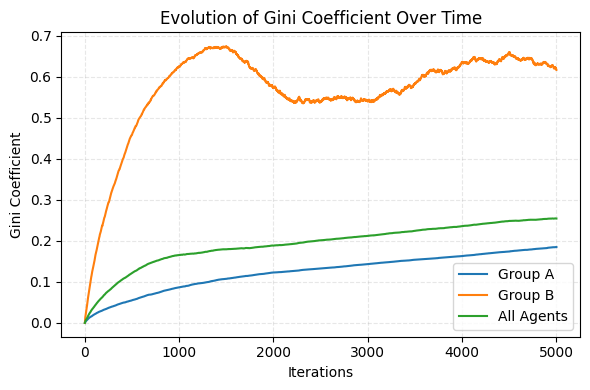

In [42]:
## Gini 
t_max = len(next(iter(game.population["A"].values())).fitness_hist)

gini_A_values = []
gini_B_values = []
gini_all_values = []

for t in range(t_max):
    fitness_A = np.array([agent.fitness_hist[t] for agent in game.population["A"].values()])
    fitness_B = np.array([agent.fitness_hist[t] for agent in game.population["B"].values()])
    fitness_all = np.concatenate([fitness_A, fitness_B])

    gini_A_values.append(gini_coefficient(fitness_A))
    gini_B_values.append(gini_coefficient(fitness_B))
    gini_all_values.append(gini_coefficient(fitness_all))

## Plot
plt.figure(figsize=(6, 4))
plt.plot(gini_A_values, label="Group A")
plt.plot(gini_B_values, label="Group B")
plt.plot(gini_all_values, label="All Agents")
plt.xlabel("Iterations")
plt.ylabel("Gini Coefficient")
plt.title("Evolution of Gini Coefficient Over Time")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## **New params**

In [51]:
### Params 
n_a = 350
n_b = 200
grid_size = 25
eta = 5
x = 0.01

In [52]:
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 931.17it/s]


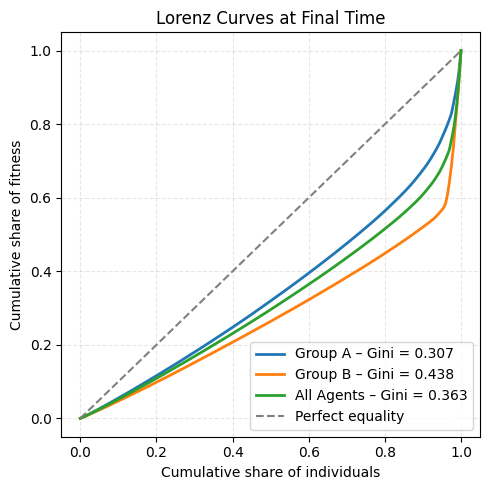

In [53]:
## Lorenz curves
fitness_start_A = np.array([agent.fitness_hist[0] for agent in game.population["A"].values()])
fitness_end_A = np.array([agent.fitness_hist[-1] for agent in game.population["A"].values()])

fitness_start_B = np.array([agent.fitness_hist[0] for agent in game.population["B"].values()])
fitness_end_B = np.array([agent.fitness_hist[-1] for agent in game.population["B"].values()])

fitness_start_all = np.concatenate([fitness_start_A, fitness_start_B])
fitness_end_all = np.concatenate([fitness_end_A, fitness_end_B])

xA_end, yA_end = lorenz_curve(fitness_end_A)
xB_end, yB_end = lorenz_curve(fitness_end_B)
xAll_end, yAll_end = lorenz_curve(fitness_end_all)

## Gini coefficients
gini_A = gini_coefficient(fitness_end_A)
gini_B = gini_coefficient(fitness_end_B)
gini_all = gini_coefficient(fitness_end_all)

## Plots
plt.figure(figsize=(5, 5))

plt.plot(xA_end, yA_end, label=f"Group A – Gini = {gini_A:.3f}", linewidth=2)
plt.plot(xB_end, yB_end, label=f"Group B – Gini = {gini_B:.3f}", linewidth=2)
plt.plot(xAll_end, yAll_end, label=f"All Agents – Gini = {gini_all:.3f}", linewidth=2)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect equality")

plt.title("Lorenz Curves at Final Time")
plt.xlabel("Cumulative share of individuals")
plt.ylabel("Cumulative share of fitness")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


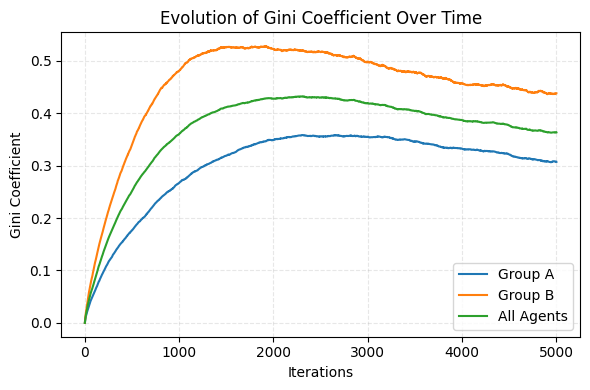

In [54]:
## Gini 
t_max = len(next(iter(game.population["A"].values())).fitness_hist)

gini_A_values = []
gini_B_values = []
gini_all_values = []

for t in range(t_max):
    fitness_A = np.array([agent.fitness_hist[t] for agent in game.population["A"].values()])
    fitness_B = np.array([agent.fitness_hist[t] for agent in game.population["B"].values()])
    fitness_all = np.concatenate([fitness_A, fitness_B])

    gini_A_values.append(gini_coefficient(fitness_A))
    gini_B_values.append(gini_coefficient(fitness_B))
    gini_all_values.append(gini_coefficient(fitness_all))

## Plot
plt.figure(figsize=(6, 4))
plt.plot(gini_A_values, label="Group A")
plt.plot(gini_B_values, label="Group B")
plt.plot(gini_all_values, label="All Agents")
plt.xlabel("Iterations")
plt.ylabel("Gini Coefficient")
plt.title("Evolution of Gini Coefficient Over Time")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## **Impact of Na/Nb, Nb, phase diagram on the emergence of a winner**

In [ ]:
## TO DO 